# Benchmarking

> Comparing the DRSA model to some other baseline models.

* *Note*: with the drsa, we can use embeddings. With the other models we cannot.

In [25]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F

# from drsa.functions import event_time_loss, event_rate_loss
from drsa.model import DRSA

from pull_the_pitcher.data.pipeline import add_targets
from pull_the_pitcher.metrics import preds_histogram, print_all_metrics

In [3]:
train = pd.read_csv("../data/processed/train_2017_2018_2019.csv")
test = pd.read_csv("../data/processed/test_2017_2018_2019.csv")
with open("../data/processed/mappers_2017_2018_2019_2017_2018_2019.pkl", "rb") as f:
    mappers = pickle.load(f)

In [4]:
embedding_cols = ["pitcher"] # ["game_pk",  "game_type", "pitcher_team_year"]
feature_cols = ["post_bat_score", "score_diff", "end_inning", "inning", "postouts", "cum_sb_ratio",
                "times_thru_order", "post_total_runners", "tying_run_on", "pitch_total", "post_opposite_hand",
                "walk", 'walk_cumsum', 'strikeout_cumsum', 'home_run_cumsum', 'bases_cumsum']
cols = embedding_cols + feature_cols

## Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
X_train, X_test, y_train, y_test = train[feature_cols], test[feature_cols], train["pulled"], test["pulled"] 

In [7]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);

/Users/collinprather/anaconda3/envs/orioles/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     36414
         1.0       0.59      0.17      0.27      1604

    accuracy                           0.96     38018
   macro avg       0.78      0.58      0.62     38018
weighted avg       0.95      0.96      0.95     38018

mean plate appearance diff: 0.27618
mean target diff: 0.02937


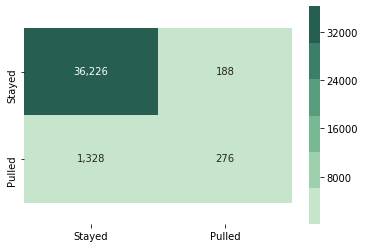

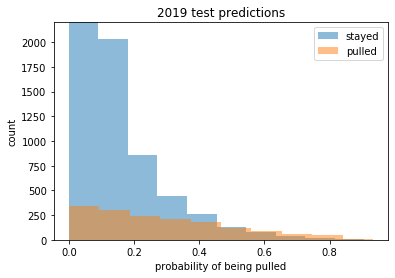

In [8]:
print_all_metrics(y_test, log_reg.predict_proba(X_test)[:, 1], thresh=0.5)

In [9]:
for feature, coef in zip(feature_cols, log_reg.coef_[0]):
    print(f"{feature}: {round(coef, 4)}")

post_bat_score: 0.0799
score_diff: -0.0353
end_inning: -1.5445
inning: -0.103
postouts: 0.2652
cum_sb_ratio: -4.1596
times_thru_order: 1.5423
post_total_runners: 0.4897
tying_run_on: -0.2067
pitch_total: 0.0567
post_opposite_hand: 0.3086
walk: -0.0969
walk_cumsum: -0.1911
strikeout_cumsum: 0.1086
home_run_cumsum: 0.1204
bases_cumsum: -0.0257


## Gradient-Boosted Tree

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
gbt = GradientBoostingClassifier(subsample=0.5)
gbt.fit(X_train, y_train);

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     36414
         1.0       0.63      0.33      0.44      1604

    accuracy                           0.96     38018
   macro avg       0.80      0.66      0.71     38018
weighted avg       0.96      0.96      0.96     38018

mean plate appearance diff: 0.23753
mean target diff: 0.02796


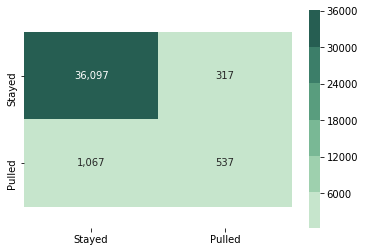

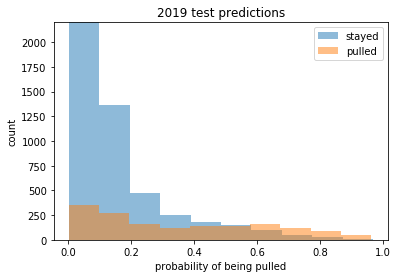

In [12]:
print_all_metrics(y_test, gbt.predict_proba(X_test)[:, 1], thresh=0.5)

## DRSA

In [26]:
def get_starts(df, cols, y_col="last_batter"):
    """
    Given a dataframe with many pitcher outings stacked on top of one another,
    this function extracts each individual outing
    """
    start_stats = np.array(df[cols])
    removal = np.array(df[y_col])
    pulled_idx = np.nonzero(removal)[0]
    stats = []
    for i in range(pulled_idx.shape[0]):
        if i == 0:
            stat = start_stats[: pulled_idx[i] + 1]
        else:
            stat = start_stats[pulled_idx[i - 1] + 1: pulled_idx[i] + 1]

        stats.append(stat)
    return stats
    
def front_pad(starts):
    """
    starts is a list of np arrays. Each has a shape of
    (# batters faced, # features)
    """
    n_features = starts[0].shape[1]
    longest = np.max([start.shape[0] for start in starts])
    padded_starts = []
    for start in starts:
        length = start.shape[0]
        difference = longest - length
        pad = np.zeros((difference, n_features)) # this also just puts a zero in for the target
        padded_start = np.vstack([pad, start])
        padded_starts.append(padded_start)
    return padded_starts

In [29]:
# quick dropping of a few unneeded columns
# train = train.drop(columns=['game_type', 'pitcher_team_year'])
# test = test.drop(columns=['game_type', 'pitcher_team_year'])

In [30]:
# getting each individual start
train_starts = get_starts(train, cols=cols, y_col="pulled")
test_starts = get_starts(test, cols=cols, y_col="pulled")

# adding targets back
train_starts = add_targets(train_starts)
test_starts = add_targets(test_starts)

# front-padding for parallelized training
padded_train_starts = front_pad(train_starts)
padded_test_starts = front_pad(test_starts)

In [31]:
class PTPDataset(Dataset):
    def __init__(self, starts):
        """
        starts is a list of np arrays. Each has a shape of
        (# batters faced, # features)
        """
        self.starts = starts
    
    def __len__(self):
        return len(self.starts)
    
    def __getitem__(self, idx):
        # ignoring first col, which is game_pk (unique identifier for each game)
        X = torch.tensor(self.starts[idx][:, 1:-1].astype(float), dtype=torch.double)
        y = torch.tensor(self.starts[idx][:, -1], dtype=torch.double).unsqueeze(-1)
        return X, y

In [32]:
# instantiating datasets and data loaders
train_ds = PTPDataset(padded_train_starts)
valid_ds = PTPDataset(padded_test_starts)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

In [33]:
def save_model(m, p): torch.save(m.state_dict(), p)
def load_model(m, p): m.load_state_dict(torch.load(p))

In [34]:
# getting embeddings ready
n_pitchers = 280
pitcher_emb_size = 20
pitcher_embeddings = nn.Embedding(n_pitchers, pitcher_emb_size)

ptp_embeddings = [pitcher_embeddings]

# initializing model
drsa = DRSA(n_features=16,
            hidden_dim=20,
            n_layers=5,
            embeddings=ptp_embeddings,
            output_size=1,
            LSTM_dropout=0.0,
            Linear_dropout=0.0)

In [35]:
! ls ../models/

06-17-20_DRSA_2017_2018_2019_loss_0.084.pth
06-17-20_DRSA_2017_2018_2019_loss_1.7337.pth


In [36]:
# loading up saved model
load_model(drsa, f"../models/06-17-20_DRSA_2017_2018_2019_loss_0.084.pth")
drsa.eval()

# organizing val preds in df
valid_features = np.concatenate(padded_test_starts, axis=0)
preds = []
for X_valid, y_valid in valid_dl:
    pred = drsa(X_valid).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
valid_df = pd.DataFrame(np.hstack([valid_features, preds]), columns=cols+["last_batter", "pred"])
    
# organizing train preds in df
train_features = np.concatenate(padded_train_starts, axis=0)
preds = []
for X_train, y_train in train_dl:
    pred = drsa(X_train).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
train_df = pd.DataFrame(np.hstack([train_features, preds]), columns=cols+["last_batter", "pred"])

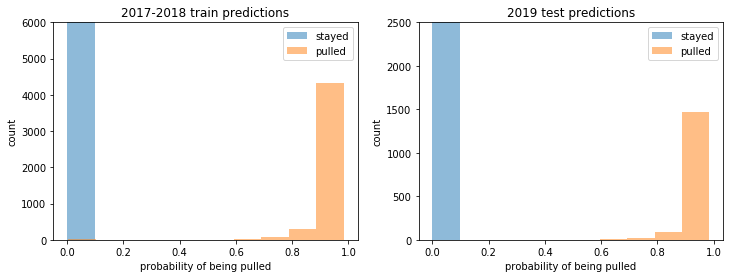

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
preds_histogram(train_df["last_batter"], train_df["pred"], ax=ax[0], ylim = (0, 6000), title="2017-2018 train predictions")
preds_histogram(valid_df["last_batter"], valid_df["pred"], ax=ax[1], ylim=(0, 2500), title="2019 test predictions")

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56140
         1.0       1.00      1.00      1.00      1604

    accuracy                           1.00     57744
   macro avg       1.00      1.00      1.00     57744
weighted avg       1.00      1.00      1.00     57744

mean plate appearance diff: 0.00499
mean target diff: 0.00095


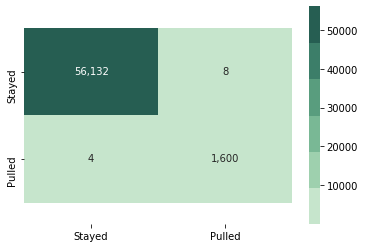

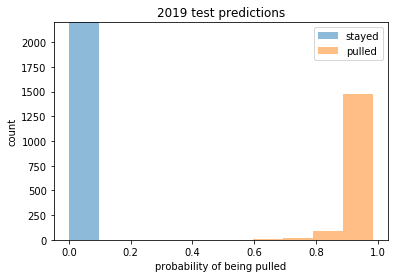

In [37]:
print_all_metrics(valid_df["last_batter"], valid_df["pred"], thresh=0.5)